## FIRST MODEL
DETECTING MELANOMAS BY COMPUTER VISION


prueba con dataset original desbalanceado


Importation of libraries

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ReduceLROnPlateau, ModelCheckpoint

## LOADING AND PREPROCESSING


As we found in the preprocessing part, we have on hte training file:

Total benign images: 6705
Total malignant images: 1113

Where we can see that we have much less data in the malignant folder, so it is advisable to perform data augmentation to more efficiently achieve the balance between classes and thus better learn the characteristics of both classes.

We also add 1140 images from other dataset to balance data

In [26]:


# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directorios para cada clase

benign_dir = os.path.join(train_dir, 'benign_images')
malignant_dir = os.path.join(train_dir, 'malignant_images')


print(f"Total de imágenes benignas en el train: {len(os.listdir(benign_dir))}")
print(f"Total de imágenes malignas en el train: {len(os.listdir(malignant_dir))}")
print(f"Total de imágenes: ",len(os.listdir(benign_dir)) +len(os.listdir(malignant_dir)) )


Total de imágenes benignas en el train: 6705
Total de imágenes malignas en el train: 1113
Total de imágenes:  7818


In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Mayor rango de rotación
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,         # Incluir shear
    zoom_range=0.2,          # Zoom aleatorio
    horizontal_flip=True,
    vertical_flip=True,      # Añadir volteo vertical
    fill_mode='nearest'
)



train_generator = train_datagen.flow_from_directory(
    train_dir,  # Ahora contiene las imágenes aumentadas en malignant_combined
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Generador para test (sin cambios)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Classes learned:", train_generator.class_indices)

Found 7818 images belonging to 2 classes.
Found 1079 images belonging to 2 classes.
Classes learned: {'benign_images': 0, 'malignant_images': 1}


We have achived a best balance between the two classes

In [28]:
class BinaryF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
        
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


In [29]:
from tensorflow.keras.optimizers import Adam



model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilación del modelo con métricas compatibles
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # LR más bajo
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        # Reemplazamos FBetaScore con una implementación segura
        BinaryF1Score()  # Definida abajo
    ]
)


c:\Users\jakif\anaconda3\envs\COMPUTER_VISION\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
best_recall = -np.inf
best_f1 = -np.inf
best_loss = np.inf

def save_on_improvement(epoch, logs):
    global best_recall, best_f1, best_loss
    
    current_recall = logs.get('val_recall', 0)
    current_f1 = logs.get('val_f1_score', 0)
    current_loss = logs.get('val_loss', np.inf)
    
    # Guardamos si mejora F1-score (prioritario) o recall con mejor loss
    if (current_f1 > best_f1) or (current_recall > best_recall and current_loss < best_loss):
        if current_f1 > best_f1:
            best_f1 = current_f1
        if current_recall > best_recall:
            best_recall = current_recall
        if current_loss < best_loss:
            best_loss = current_loss
            
        model.save(f'best_model_epoch_{epoch}_f1_{current_f1:.4f}.h5')
        print(f"Improved model - F1: {current_f1:.4f}, Recall: {current_recall:.4f}, Loss: {current_loss:.4f}")

# Configuración de callbacks
callbacks = [
    EarlyStopping(
        monitor='val_f1_score',  # Monitoreamos F1-score
        mode='max',
        patience=15,  # Paciencia aumentada
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # Reducción más agresiva
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_f1.h5',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    LambdaCallback(on_epoch_end=save_on_improvement)
]

# Resumen del modelo
model.summary()

# Entrenamiento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\jakif\anaconda3\envs\COMPUTER_VISION\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8597 - auc: 0.6278 - f1_score: 0.0117 - loss: 0.4040 - precision: 0.3401 - recall: 0.0077
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.0000, Recall: 0.0000, Loss: 0.3820
245/245 ━━━━━━━━━━━━━━━━━━━━ 133s 536ms/step - accuracy: 0.8597 - auc: 0.6282 - f1_score: 0.0117 - loss: 0.4039 - precision: 0.3408 - recall: 0.0076 - val_accuracy: 0.8415 - val_auc: 0.7608 - val_f1_score: 0.0000e+00 - val_loss: 0.3820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8615 - auc: 0.8066 - f1_score: 0.0137 - loss: 0.3236 - precision: 0.3954 - recall: 0.0070
Epoch 2: val_f1_score improved from 0.00000 to 0.25000, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.2500, Recall: 0.1696, Loss: 0.3299
245/245 ━━━━━━━━━━━━━━━━━━━━ 121s 495ms/step - accuracy: 0.8614 - auc: 0.8066 - f1_score: 0.0137 - loss: 0.3236 - precision: 0.3961 - recall: 0.0070 - val_accuracy: 0.8387 - val_auc: 0.8359 - val_f1_score: 0.2500 - val_loss: 0.3299 - val_precision: 0.4754 - val_recall: 0.1696 - learning_rate: 1.0000e-04
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8620 - auc: 0.8347 - f1_score: 0.1767 - loss: 0.3058 - precision: 0.5411 - recall: 0.1061
Epoch 3: val_f1_score improved from 0.25000 to 0.28689, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.2869, Recall: 0.2047, Loss: 0.3289
245/245 ━━━━━━━━━━━━━━━━━━━━ 122s 499ms/step - accuracy: 0.8620 - auc: 0.8347 - f1_score: 0.1768 - loss: 0.3058 - precision: 0.5411 - recall: 0.1061 - val_accuracy: 0.8387 - val_auc: 0.8315 - val_f1_score: 0.2869 - val_loss: 0.3289 - val_precision: 0.4795 - val_recall: 0.2047 - learning_rate: 1.0000e-04
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8615 - auc: 0.8421 - f1_score: 0.1942 - loss: 0.3023 - precision: 0.5213 - recall: 0.1197
Epoch 4: val_f1_score improved from 0.28689 to 0.34008, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.3401, Recall: 0.2456, Loss: 0.3152
245/245 ━━━━━━━━━━━━━━━━━━━━ 129s 526ms/step - accuracy: 0.8615 - auc: 0.8421 - f1_score: 0.1944 - loss: 0.3023 - precision: 0.5215 - recall: 0.1198 - val_accuracy: 0.8489 - val_auc: 0.8527 - val_f1_score: 0.3401 - val_loss: 0.3152 - val_precision: 0.5526 - val_recall: 0.2456 - learning_rate: 1.0000e-04
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8596 - auc: 0.8515 - f1_score: 0.2491 - loss: 0.2999 - precision: 0.5371 - recall: 0.1628
Epoch 5: val_f1_score improved from 0.34008 to 0.36735, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.3673, Recall: 0.2632, Loss: 0.3261
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 484ms/step - accuracy: 0.8596 - auc: 0.8515 - f1_score: 0.2490 - loss: 0.2999 - precision: 0.5371 - recall: 0.1627 - val_accuracy: 0.8563 - val_auc: 0.8434 - val_f1_score: 0.3673 - val_loss: 0.3261 - val_precision: 0.6081 - val_recall: 0.2632 - learning_rate: 1.0000e-04
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8617 - auc: 0.8564 - f1_score: 0.2088 - loss: 0.2954 - precision: 0.5303 - recall: 0.1304
Epoch 6: val_f1_score did not improve from 0.36735
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 478ms/step - accuracy: 0.8617 - auc: 0.8565 - f1_score: 0.2091 - loss: 0.2954 - precision: 0.5306 - recall: 0.1306 - val_accuracy: 0.8554 - val_auc: 0.8550 - val_f1_score: 0.2909 - val_loss: 0.3146 - val_precision: 0.6531 - val_recall: 0.1871 - learning_rate: 1.0000e-04
Epoch 7/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8607 - auc: 0.8623 - f1_score: 0.2974 - loss: 0.2992

Modelo mejorado - F1: 0.5198, Recall: 0.5380, Loss: 0.3174
245/245 ━━━━━━━━━━━━━━━━━━━━ 118s 480ms/step - accuracy: 0.8608 - auc: 0.8624 - f1_score: 0.2975 - loss: 0.2991 - precision: 0.5978 - recall: 0.2001 - val_accuracy: 0.8424 - val_auc: 0.8747 - val_f1_score: 0.5198 - val_loss: 0.3174 - val_precision: 0.5027 - val_recall: 0.5380 - learning_rate: 1.0000e-04
Epoch 8/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8707 - auc: 0.8687 - f1_score: 0.3548 - loss: 0.2836 - precision: 0.5954 - recall: 0.2535
Epoch 8: val_f1_score did not improve from 0.51977
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 484ms/step - accuracy: 0.8707 - auc: 0.8688 - f1_score: 0.3550 - loss: 0.2836 - precision: 0.5955 - recall: 0.2537 - val_accuracy: 0.8730 - val_auc: 0.8794 - val_f1_score: 0.4669 - val_loss: 0.2957 - val_precision: 0.6977 - val_recall: 0.3509 - learning_rate: 1.0000e-04
Epoch 9/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8753 - auc: 0.8725 - f1_score: 0.4040 - loss: 0.2814

Modelo mejorado - F1: 0.5376, Recall: 0.4386, Loss: 0.2787
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 484ms/step - accuracy: 0.8753 - auc: 0.8725 - f1_score: 0.4041 - loss: 0.2814 - precision: 0.6341 - recall: 0.2986 - val_accuracy: 0.8804 - val_auc: 0.8955 - val_f1_score: 0.5376 - val_loss: 0.2787 - val_precision: 0.6944 - val_recall: 0.4386 - learning_rate: 1.0000e-04
Epoch 10/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8808 - auc: 0.8861 - f1_score: 0.4364 - loss: 0.2690 - precision: 0.6407 - recall: 0.3318
Epoch 10: val_f1_score did not improve from 0.53763
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 477ms/step - accuracy: 0.8808 - auc: 0.8861 - f1_score: 0.4365 - loss: 0.2690 - precision: 0.6408 - recall: 0.3318 - val_accuracy: 0.8703 - val_auc: 0.8900 - val_f1_score: 0.3966 - val_loss: 0.2885 - val_precision: 0.7541 - val_recall: 0.2690 - learning_rate: 1.0000e-04
Epoch 11/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8905 - auc: 0.8933 - f1_score: 0.4768 - loss: 0.2

Modelo mejorado - F1: 0.5733, Recall: 0.5146, Loss: 0.2818
245/245 ━━━━━━━━━━━━━━━━━━━━ 120s 489ms/step - accuracy: 0.8844 - auc: 0.8997 - f1_score: 0.5185 - loss: 0.2595 - precision: 0.6617 - recall: 0.4273 - val_accuracy: 0.8786 - val_auc: 0.8938 - val_f1_score: 0.5733 - val_loss: 0.2818 - val_precision: 0.6471 - val_recall: 0.5146 - learning_rate: 1.0000e-04
Epoch 13/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8743 - auc: 0.8876 - f1_score: 0.4597 - loss: 0.2739 - precision: 0.6177 - recall: 0.3668
Epoch 13: val_f1_score did not improve from 0.57329
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 485ms/step - accuracy: 0.8743 - auc: 0.8876 - f1_score: 0.4597 - loss: 0.2739 - precision: 0.6178 - recall: 0.3668 - val_accuracy: 0.8786 - val_auc: 0.8972 - val_f1_score: 0.5467 - val_loss: 0.2750 - val_precision: 0.6695 - val_recall: 0.4620 - learning_rate: 1.0000e-04
Epoch 14/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8850 - auc: 0.9083 - f1_score: 0.5253 - loss: 0.2

Modelo mejorado - F1: 0.5939, Recall: 0.5731, Loss: 0.2794
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 486ms/step - accuracy: 0.8848 - auc: 0.8989 - f1_score: 0.4770 - loss: 0.2591 - precision: 0.6534 - recall: 0.3801 - val_accuracy: 0.8758 - val_auc: 0.8996 - val_f1_score: 0.5939 - val_loss: 0.2794 - val_precision: 0.6164 - val_recall: 0.5731 - learning_rate: 1.0000e-04
Epoch 16/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8927 - auc: 0.9142 - f1_score: 0.5395 - loss: 0.2431 - precision: 0.6984 - recall: 0.4421
Epoch 16: val_f1_score did not improve from 0.59394
245/245 ━━━━━━━━━━━━━━━━━━━━ 118s 483ms/step - accuracy: 0.8927 - auc: 0.9141 - f1_score: 0.5394 - loss: 0.2431 - precision: 0.6984 - recall: 0.4420 - val_accuracy: 0.8832 - val_auc: 0.9065 - val_f1_score: 0.5625 - val_loss: 0.2638 - val_precision: 0.6923 - val_recall: 0.4737 - learning_rate: 1.0000e-04
Epoch 17/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8864 - auc: 0.8984 - f1_score: 0.5080 - loss: 0.2

Modelo mejorado - F1: 0.6175, Recall: 0.6608, Loss: 0.2778
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 485ms/step - accuracy: 0.8864 - auc: 0.8984 - f1_score: 0.5080 - loss: 0.2592 - precision: 0.6728 - recall: 0.4088 - val_accuracy: 0.8703 - val_auc: 0.9074 - val_f1_score: 0.6175 - val_loss: 0.2778 - val_precision: 0.5795 - val_recall: 0.6608 - learning_rate: 1.0000e-04
Epoch 18/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8818 - auc: 0.8981 - f1_score: 0.5055 - loss: 0.2624 - precision: 0.6553 - recall: 0.4124
Epoch 18: val_f1_score did not improve from 0.61749
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 486ms/step - accuracy: 0.8818 - auc: 0.8981 - f1_score: 0.5054 - loss: 0.2623 - precision: 0.6553 - recall: 0.4124 - val_accuracy: 0.8851 - val_auc: 0.9028 - val_f1_score: 0.5634 - val_loss: 0.2675 - val_precision: 0.7080 - val_recall: 0.4678 - learning_rate: 1.0000e-04
Epoch 19/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8807 - auc: 0.8958 - f1_score: 0.4963 - loss: 0.2

Modelo mejorado - F1: 0.6228, Recall: 0.6082, Loss: 0.2680
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 486ms/step - accuracy: 0.8807 - auc: 0.8958 - f1_score: 0.4964 - loss: 0.2640 - precision: 0.6516 - recall: 0.4013 - val_accuracy: 0.8832 - val_auc: 0.9088 - val_f1_score: 0.6228 - val_loss: 0.2680 - val_precision: 0.6380 - val_recall: 0.6082 - learning_rate: 1.0000e-04
Epoch 20/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8942 - auc: 0.9036 - f1_score: 0.5364 - loss: 0.2503 - precision: 0.6852 - recall: 0.4412
Epoch 20: val_f1_score did not improve from 0.62275
245/245 ━━━━━━━━━━━━━━━━━━━━ 122s 497ms/step - accuracy: 0.8941 - auc: 0.9036 - f1_score: 0.5363 - loss: 0.2503 - precision: 0.6851 - recall: 0.4412 - val_accuracy: 0.8832 - val_auc: 0.9132 - val_f1_score: 0.5828 - val_loss: 0.2584 - val_precision: 0.6718 - val_recall: 0.5146 - learning_rate: 1.0000e-04
Epoch 21/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8897 - auc: 0.8951 - f1_score: 0.4886 - loss: 0.2

Modelo mejorado - F1: 0.6261, Recall: 0.6023, Loss: 0.2572
245/245 ━━━━━━━━━━━━━━━━━━━━ 124s 504ms/step - accuracy: 0.8897 - auc: 0.8951 - f1_score: 0.4888 - loss: 0.2580 - precision: 0.6777 - recall: 0.3864 - val_accuracy: 0.8860 - val_auc: 0.9164 - val_f1_score: 0.6261 - val_loss: 0.2572 - val_precision: 0.6519 - val_recall: 0.6023 - learning_rate: 1.0000e-04
Epoch 22/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8905 - auc: 0.9105 - f1_score: 0.5604 - loss: 0.2497 - precision: 0.6889 - recall: 0.4727
Epoch 22: val_f1_score did not improve from 0.62614
245/245 ━━━━━━━━━━━━━━━━━━━━ 121s 494ms/step - accuracy: 0.8905 - auc: 0.9105 - f1_score: 0.5603 - loss: 0.2497 - precision: 0.6889 - recall: 0.4725 - val_accuracy: 0.8814 - val_auc: 0.9132 - val_f1_score: 0.5188 - val_loss: 0.2592 - val_precision: 0.7263 - val_recall: 0.4035 - learning_rate: 1.0000e-04
Epoch 23/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8965 - auc: 0.9113 - f1_score: 0.5553 - loss: 0.2

Modelo mejorado - F1: 0.6273, Recall: 0.5906, Loss: 0.2579
245/245 ━━━━━━━━━━━━━━━━━━━━ 120s 491ms/step - accuracy: 0.8992 - auc: 0.9156 - f1_score: 0.5638 - loss: 0.2428 - precision: 0.7605 - recall: 0.4497 - val_accuracy: 0.8888 - val_auc: 0.9109 - val_f1_score: 0.6273 - val_loss: 0.2579 - val_precision: 0.6689 - val_recall: 0.5906 - learning_rate: 2.0000e-05
Epoch 28/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8931 - auc: 0.9162 - f1_score: 0.5516 - loss: 0.2390 - precision: 0.6936 - recall: 0.4586
Epoch 28: val_f1_score improved from 0.62733 to 0.62963, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.6296, Recall: 0.5965, Loss: 0.2561
245/245 ━━━━━━━━━━━━━━━━━━━━ 122s 499ms/step - accuracy: 0.8931 - auc: 0.9162 - f1_score: 0.5518 - loss: 0.2390 - precision: 0.6937 - recall: 0.4587 - val_accuracy: 0.8888 - val_auc: 0.9147 - val_f1_score: 0.6296 - val_loss: 0.2561 - val_precision: 0.6667 - val_recall: 0.5965 - learning_rate: 2.0000e-05
Epoch 29/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9039 - auc: 0.9239 - f1_score: 0.5908 - loss: 0.2270 - precision: 0.7406 - recall: 0.4922
Epoch 29: val_f1_score improved from 0.62963 to 0.65455, saving model to best_model_f1.h5


Modelo mejorado - F1: 0.6545, Recall: 0.6316, Loss: 0.2578
245/245 ━━━━━━━━━━━━━━━━━━━━ 121s 494ms/step - accuracy: 0.9039 - auc: 0.9239 - f1_score: 0.5908 - loss: 0.2270 - precision: 0.7406 - recall: 0.4923 - val_accuracy: 0.8943 - val_auc: 0.9136 - val_f1_score: 0.6545 - val_loss: 0.2578 - val_precision: 0.6792 - val_recall: 0.6316 - learning_rate: 2.0000e-05
Epoch 30/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9005 - auc: 0.9236 - f1_score: 0.5734 - loss: 0.2232 - precision: 0.6869 - recall: 0.4929
Epoch 30: val_f1_score did not improve from 0.65455
245/245 ━━━━━━━━━━━━━━━━━━━━ 120s 490ms/step - accuracy: 0.9005 - auc: 0.9236 - f1_score: 0.5734 - loss: 0.2233 - precision: 0.6869 - recall: 0.4929 - val_accuracy: 0.8851 - val_auc: 0.9135 - val_f1_score: 0.5867 - val_loss: 0.2538 - val_precision: 0.6822 - val_recall: 0.5146 - learning_rate: 2.0000e-05
Epoch 31/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9003 - auc: 0.9221 - f1_score: 0.6010 - loss: 0.2

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.8855 - auc: 0.9103 - f1_score: 0.6267 - loss: 0.2668 - precision: 0.6441 - recall: 0.6133

    loss: 0.2578
    Accuracy: 89.43%
    Precision: 67.92%
    Recall: 63.16%
    AUC: 91.36%
    F1 Score: 65.45%



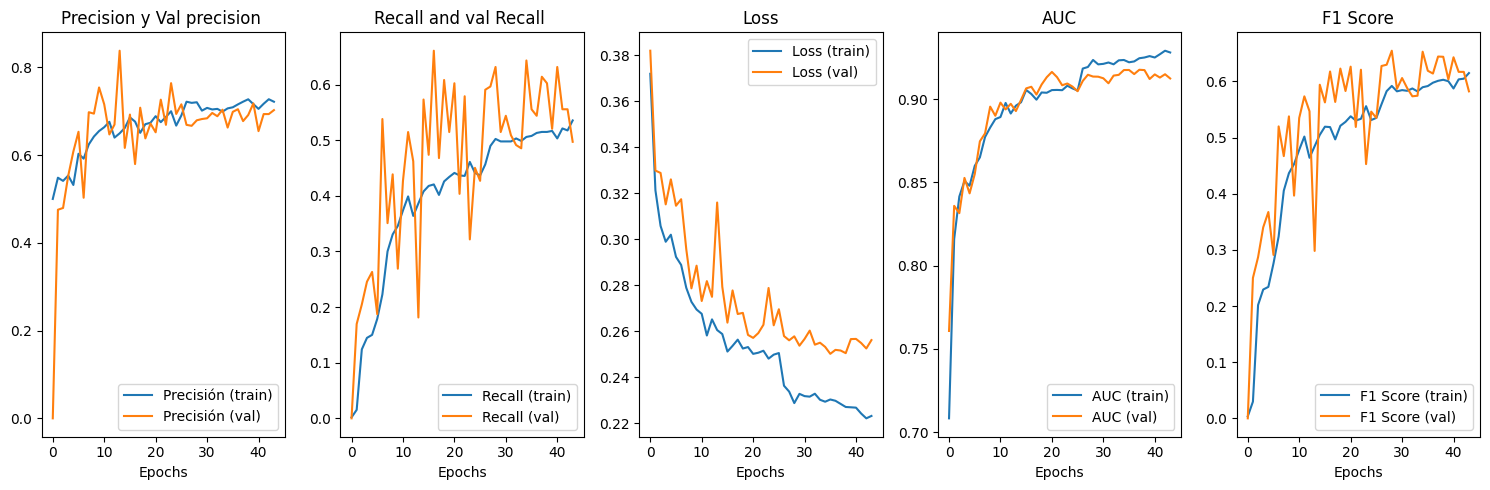

In [32]:
# Evaluar el modelo en el conjunto de prueba

results = model.evaluate(test_generator)  # Devuelve [loss, accuracy, precision, recall, auc, f1_score]
print(f'''
    loss: {results[0]:.4f}
    Accuracy: {results[1]*100:.2f}%
    Precision: {results[2]*100:.2f}%
    Recall: {results[3]*100:.2f}%
    AUC: {results[4]*100:.2f}%
    F1 Score: {results[5]*100:.2f}%
''')


# Graficar la precisión y la pérdida
plt.figure(figsize=(15, 5))

# Gráfico 1: Precisión y Recall de entrenamiento
plt.subplot(1, 5, 1)
plt.plot(history.history['precision'], label='Precisión (train)')
plt.plot(history.history['val_precision'], label='Precisión (val)')

plt.title('Precision y Val precision ')
plt.xlabel('Epochs')
plt.legend()

# Gráfico 2: Precisión y Recall de validación
plt.subplot(1, 5, 2)
plt.plot(history.history['recall'], label='Recall (train)')
plt.plot(history.history['val_recall'], label='Recall (val)')
plt.title('Recall and val Recall ')
plt.xlabel('Epochs')
plt.legend()

# Gráfico 3: Pérdida
plt.subplot(1, 5, 3)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Gráfico 4: AUC
plt.subplot(1, 5, 4)
plt.plot(history.history['auc'], label='AUC (train)')
plt.plot(history.history['val_auc'], label='AUC (val)')
plt.title('AUC')
plt.xlabel('Epochs')
plt.legend()

# Gráfico 5: F1 Score
plt.subplot(1, 5, 5)
plt.plot(history.history['f1_score'], label='F1 Score (train)')

plt.plot(history.history['val_f1_score'], label='F1 Score (val)')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.legend()


plt.tight_layout()
plt.show()




34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step
F1 Score: 0.15
                  precision    recall  f1-score   support

   benign_images       0.84      0.85      0.85       908
malignant_images       0.15      0.14      0.15       171

        accuracy                           0.74      1079
       macro avg       0.50      0.50      0.50      1079
    weighted avg       0.73      0.74      0.73      1079



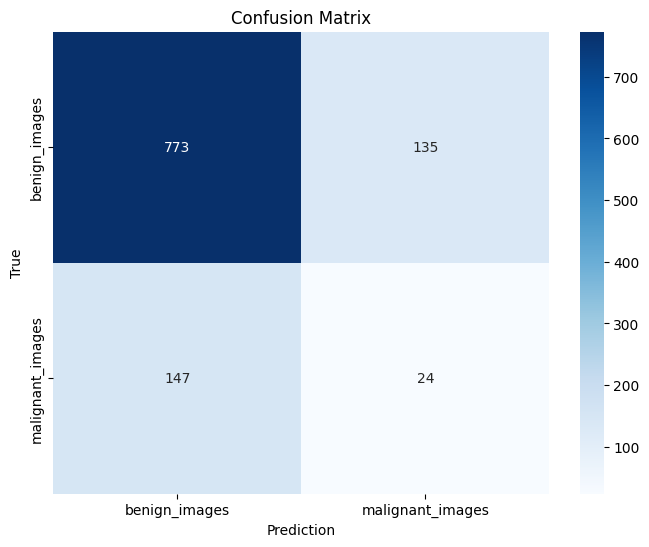

In [ ]:
#Evaluar con F1 Score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo y las etiquetas verdaderas
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()
# Calcular el F1 Score 
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}')
# Imprimir el informe de clasificación
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Prediction')
plt.ylabel('True')

plt.title('Confusion Matrix')
plt.show()